In [239]:
import pandas as pd
import datetime
import numpy as np
import scipy as sp
import os
import matplotlib.pyplot as plt
import matplotlib
# from ggplot import geom_point
%matplotlib inline
# font = {'size'   : 18}
# matplotlib.rc('font', **font)
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
os.chdir("/root/Envs/btc-project/btc-price-analysis")

## reading google trend data

Google trend data seems to be updated since the orignal google trend paper. Currently, we are unable to get the absolute search volume data. Instead, for each week, we get a [normalized search interest index](https://support.google.com/trends/answer/4365533?hl=en). This index seems to be ranging from 0 to 100. The index is normalized against the search region. Therefore, it shows more of a search "density", instead of the pure count of searches.

This update might render the replicate not possible.

In [240]:
# parse data from google trend
def parseWeek(w):
    return w.split(" - ")[1]

In this replicate, we focus on one keyword, 'Bitcoin'.

In [241]:
trend = pd.read_csv("./data/trend.csv", converters={0:parseWeek})
trend['Week'] = pd.to_datetime(trend['Week'])
trend.set_index(['Week'], inplace=True)
trend.columns = ['search']
trend.head()

,search
Week,
2012-01-07,2
2012-01-14,2
2012-01-21,4
2012-01-28,2
2012-02-04,2


We use the Bitcoin price index data from coinbase. Resample it per week starting at every Saturday to match google trend data. That means every Friday will be our action day, to either buy or sell bitcoin.

In [242]:
time_format = "%Y-%m-%dT%H:%M:%S"
data = pd.read_csv("./data/price.csv", names=['time', 'price'], index_col='time',
                   parse_dates=[0], date_parser=lambda x: datetime.datetime.strptime(x[:-6], time_format))
bpi = data.resample('w-sat', how='ohlc')
bpi.index.name = 'Week'
bpi = pd.DataFrame(bpi['price']['close'])
bpi.head()

,close
Week,
2010-07-17,0.05
2010-07-24,0.06
2010-07-31,0.06
2010-08-07,0.06
2010-08-14,0.07


In [243]:
trend_bpi = pd.merge(trend, bpi, how='right', left_index=True, right_index=True)
trend_bpi.columns = ['search', 'close_price']
trend_bpi = trend_bpi['2012':]
trend_bpi.head()

,search,close_price
Week,,
2012-01-07,2,7.00
2012-01-14,2,6.87
2012-01-21,4,6.19
2012-01-28,2,5.66
2012-02-04,2,5.72


#### BPI and search interest plot

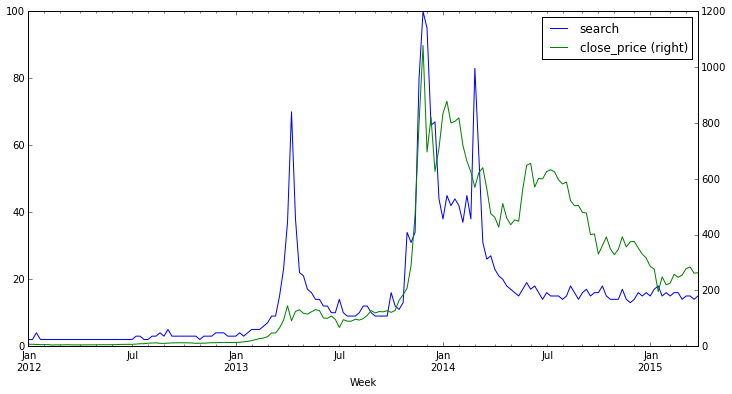

In [244]:
plt.figure()
ax = trend_bpi.plot(secondary_y=['close_price'])

Correlation given by Pearson's coefficient

In [245]:
trend_bpi.corr()

,search,close_price
search,1.000000,0.730443
close_price,0.730443,1.000000


#### BPI v. search interest (relative change)

Similar to return index, here we calculate the change of both variables (BPI and search interest) each week compared with last week. We only show 2014 to 2015 as previous variance is too big.

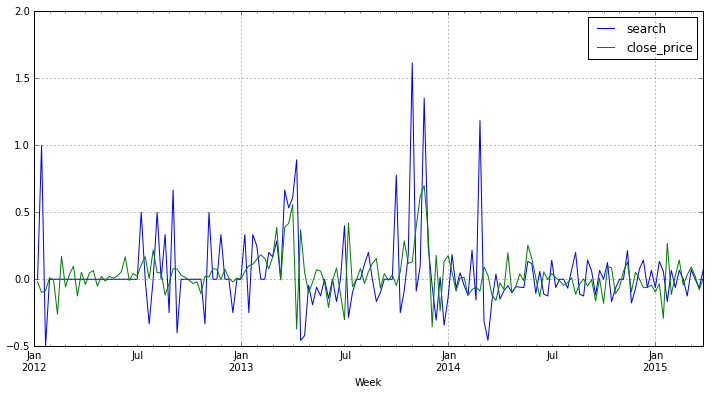

In [246]:
trend_bpi.pct_change().plot()

Again, correlation.

In [247]:
trend_bpi.pct_change().corr()

,search,close_price
search,1.000000,0.148033
close_price,0.148033,1.000000


Pearson correlation coefficient has been decreased once we start examining the return index instead of the actual value of two variables. Does this matter?

## Replicating google trend paper

We first take the moving average of the search interest index (SII).

In [248]:
delta_t = 3

trend_bpi['rolling_SII'] = pd.rolling_mean(trend_bpi.search, delta_t)
trend_bpi.head()

,search,close_price,rolling_SII
Week,,,
2012-01-07,2,7.00,NaN
2012-01-14,2,6.87,NaN
2012-01-21,4,6.19,2.666667
2012-01-28,2,5.66,2.666667
2012-02-04,2,5.72,2.666667


We shift the moving average one week ahead, as we trying to predict BPI based on previous search interest.

In [249]:
trend_bpi['rolling_SII_shifted'] = trend_bpi.rolling_SII.shift(1)
trend_bpi.head()

,search,close_price,rolling_SII,rolling_SII_shifted
Week,,,,
2012-01-07,2,7.00,NaN,NaN
2012-01-14,2,6.87,NaN,NaN
2012-01-21,4,6.19,2.666667,NaN
2012-01-28,2,5.66,2.666667,2.666667
2012-02-04,2,5.72,2.666667,2.666667


### Generate order signal

If the search interest of this week is less than the moving average of interest of the past three week (delta_t), people search less about bitcoint, therefore it is likely this is the time to buy in; otherwise, if people start searching more about bitcoin this week, it is the time to sell.

We generate `order` data. If it is a `1`, it means at that particular week we buy BTC, and sell it next week. If it is `-1`, we sell it this week and buy it back next week. 

We assign the order signal based on the comparison of this week's search interest and the rolling mean of previous three weeks' search interest.

In [268]:
trend_bpi['order']=0
trend_bpi['SII_diff'] = trend_bpi.search - trend_bpi.rolling_SII_shifted
## SII_diff >= diff => search interest rises this week => price rises next week
trend_bpi.loc[trend_bpi.SII_diff >= 0,'order'] = 1
## SII_diff < diff => search interest falls this week => price falls next week
trend_bpi.loc[trend_bpi.SII_diff < 0,'order'] = -1
trend_bpi.head()

,search,close_price,rolling_SII,rolling_SII_shifted,order,neworder,SII_diff,log_returns,truth
Week,,,,,,,,,
2012-01-07,2,7.00,NaN,NaN,0,0,NaN,0.000000,-1
2012-01-14,2,6.87,NaN,NaN,0,0,NaN,0.000000,-1
2012-01-21,4,6.19,2.666667,NaN,0,1,NaN,0.000000,-1
2012-01-28,2,5.66,2.666667,2.666667,-1,-1,-0.666667,-0.010545,-1
2012-02-04,2,5.72,2.666667,2.666667,-1,-1,-0.666667,0.003503,1


## Evaluation as returns

Compute log returns as proposed in the paper: the difference of prices of two consecutive weeks times the order signal.

In [269]:
trend_bpi['log_returns'] = trend_bpi.order * np.log(trend_bpi.close_price.shift(-1)) - \
                            trend_bpi.order * np.log(trend_bpi.close_price)

In [270]:
trend_bpi.log_returns.head()

Week
2012-01-07    0.000000
2012-01-14    0.000000
2012-01-21    0.000000
2012-01-28   -0.010545
2012-02-04    0.003503
Freq: W-SAT, Name: log_returns, dtype: float64

Positive returns indicate earning on that week.

In [271]:
trend_bpi[trend_bpi.log_returns>0].close_price.count()

95

Negative returns indicate losing on that week.

In [272]:
trend_bpi[trend_bpi.log_returns<0].close_price.count()

70

Plot cumulative returns over time.

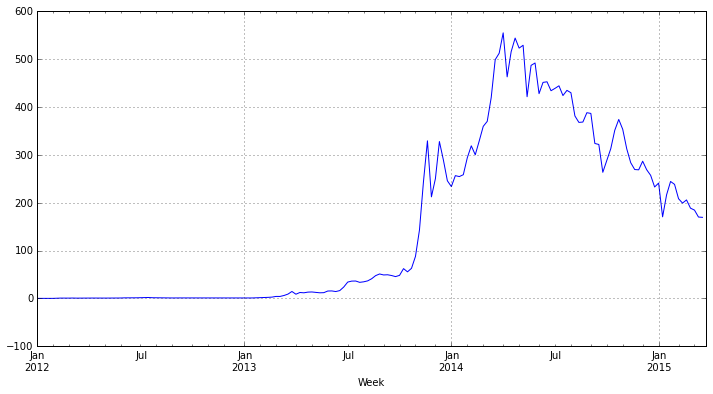

In [273]:
(np.exp(trend_bpi.log_returns.cumsum()) - 1).plot()

Plot cumulative return only for 2015

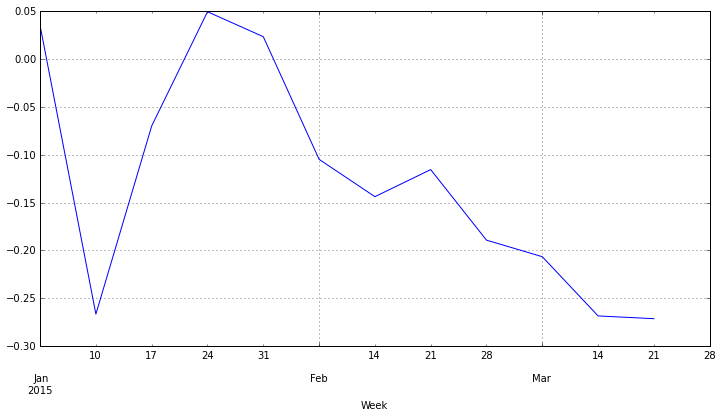

In [274]:
(np.exp(trend_bpi['2015'].log_returns.cumsum()) - 1).plot()

Plot only 2014

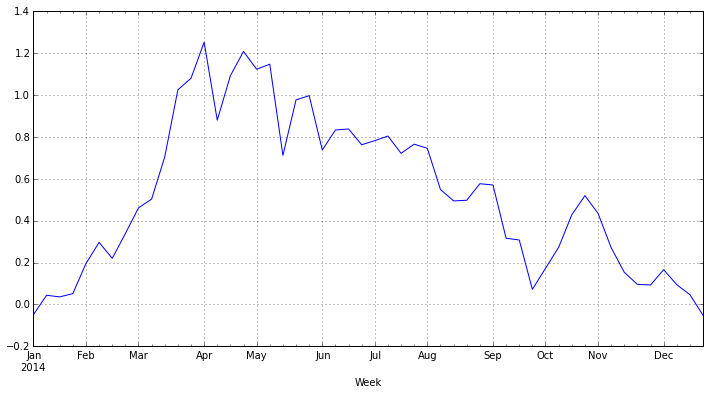

In [275]:
(np.exp(trend_bpi['2014'].log_returns.cumsum()) - 1).plot()

Plot only 2013

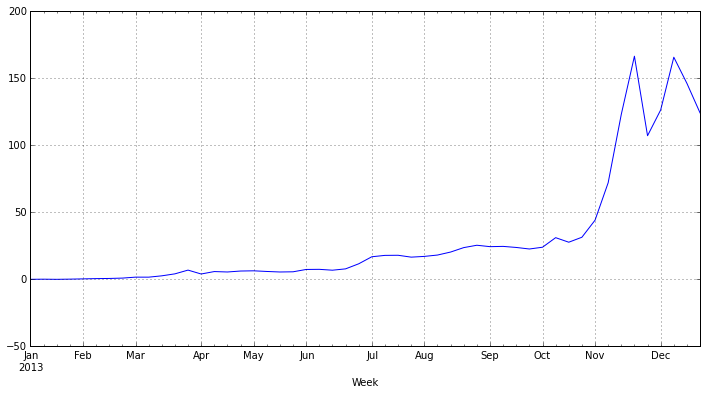

In [276]:
(np.exp(trend_bpi['2013'].log_returns.cumsum()) - 1).plot()

It seems this strategy relies on heavily the performance of earlies times (e.g. 2013), than later times. If earlier times work well, the performance overall is really good. However, cutting off earlier times the performance is much worse.

## Evaluation as prediction of trend

Label each week as up (1) and down (-1) comparing its price and that of previous week.

In [277]:
def trend_label(cur,prev):
    if cur == prev:
        return 0
    elif cur > prev:
        return 1
    else:
        return -1
trend_bpi['truth'] = np.vectorize(trend_label)(trend_bpi.close_price, trend_bpi.close_price.shift(1))
trend_bpi.head()

,search,close_price,rolling_SII,rolling_SII_shifted,order,neworder,SII_diff,log_returns,truth
Week,,,,,,,,,
2012-01-07,2,7.00,NaN,NaN,0,0,NaN,0.000000,-1
2012-01-14,2,6.87,NaN,NaN,0,0,NaN,0.000000,-1
2012-01-21,4,6.19,2.666667,NaN,0,1,NaN,0.000000,-1
2012-01-28,2,5.66,2.666667,2.666667,-1,-1,-0.666667,-0.010545,-1
2012-02-04,2,5.72,2.666667,2.666667,-1,-1,-0.666667,0.003503,1


In [278]:
trend_bpi.groupby('truth').truth.count()

truth
-1    72
 1    97
Name: truth, dtype: int64

therefore in our case "-1" is the positive case and "1" negative case.

In [279]:
trend_bpi.groupby('order').truth.count()

order
-1    74
 0     3
 1    92
Name: truth, dtype: int64

In [280]:
trend_bpi_exclude_init = trend_bpi[3:]
true_prediction = trend_bpi_exclude_init.truth==trend_bpi_exclude_init.order
correct_ratio = trend_bpi_exclude_init[true_prediction].close_price.count()/float(trend_bpi_exclude_init.close_price.count())
print "Correctly predicting trend: %f" % correct_ratio

Correctly predicting trend: 0.560241


In [281]:
true_positive = trend_bpi[(trend_bpi.truth==1)&(trend_bpi.order==1)].order.count()
false_negative = trend_bpi[(trend_bpi.truth==1)&(trend_bpi.order==-1)].order.count()
false_positive = trend_bpi[(trend_bpi.truth==-1)&(trend_bpi.order==1)].order.count()
true_negative = trend_bpi[(trend_bpi.truth==-1)&(trend_bpi.order==-1)].order.count()
print "TP: %d, FN: %d, FP: %d, TN: %d" % (true_positive, false_negative, false_positive, true_negative)

TP: 58, FN: 39, FP: 34, TN: 35


In [282]:
tp_rate = float(true_positive) /(true_positive+false_negative)
fp_rate = float(false_positive) /(true_negative+false_positive)
print "TPR: %f, FPR: %f" % (tp_rate, fp_rate)

TPR: 0.597938, FPR: 0.492754
